### Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed
import matplotlib.pyplot as plt

### Loading and Preprocessing the Dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

### Tokenization

In [3]:
eng_tokenizer = Tokenizer()
ger_tokenizer = Tokenizer()

eng_tokenizer.fit_on_texts(df['English'])
ger_tokenizer.fit_on_texts(df['German'])

eng_sequences = eng_tokenizer.texts_to_sequences(df['English'])
ger_sequences = ger_tokenizer.texts_to_sequences(df['German'])

### Padding

In [4]:
# Determining a fixed maximum length for both sequences
max_eng_len = max(len(seq) for seq in eng_sequences)
max_ger_len = max(len(seq) for seq in ger_sequences)
max_len = max(max_eng_len, max_ger_len)  


# Padding both English and German sequences to the same length
eng_padded = pad_sequences(eng_sequences, maxlen=max_len, padding='post')
ger_padded = pad_sequences(ger_sequences, maxlen=max_len, padding='post')

### Define and Train the Model

In [5]:
model = Sequential([
    Embedding(input_dim=len(eng_tokenizer.word_index) + 1, output_dim=128),
    LSTM(128, return_sequences=True),
    TimeDistributed(Dense(len(ger_tokenizer.word_index) + 1, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Expanding the target dimensions: ger_padded shape becomes (num_samples, max_len, 1)
ger_targets = np.expand_dims(ger_padded, -1)

history = model.fit(eng_padded, ger_targets, epochs=3, batch_size=32, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
6948/6948 ━━━━━━━━━━━━━━━━━━━━ 4443s 639ms/step - accuracy: 0.9515 - loss: 0.5783 - val_accuracy: 0.9215 - val_loss: 0.5812
Epoch 2/3
6948/6948 ━━━━━━━━━━━━━━━━━━━━ 4471s 643ms/step - accuracy: 0.9630 - loss: 0.2341 - val_accuracy: 0.9234 - val_loss: 0.5523
Epoch 3/3
6948/6948 ━━━━━━━━━━━━━━━━━━━━ 4475s 644ms/step - accuracy: 0.9655 - loss: 0.1995 - val_accuracy: 0.9243 - val_loss: 0.5366


### Save the Model

In [6]:
model.save("LSTM_300k.keras")

### Plot training history

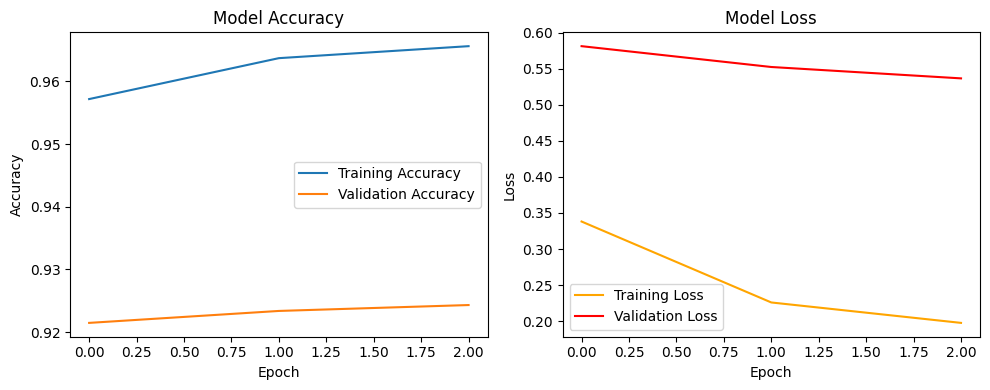

In [7]:
plt.figure(figsize=(10, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Validation

In [8]:
# Validate on 30 samples
print("\n--- Validation on 30 samples ---\n")
for i in range(30):
    eng_sentence = df['English'][i]
    actual_translation = df['German'][i]
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([eng_sentence]), maxlen=max_len, padding='post')
    
    # Get model predictions; prediction shape: (1, max_len, vocab_size)
    prediction = np.argmax(model.predict(input_seq), axis=-1)
    
    # Convert predicted indices to words; ignore padding zerosexi
    predicted_sentence = ' '.join([ger_tokenizer.index_word.get(idx, '<UNK>') 
                                   for idx in prediction[0] if idx != 0])
    print(f"English: {eng_sentence}")
    print(f"Actual German: {actual_translation}")
    print(f"Predicted German: {predicted_sentence}\n")


--- Validation on 30 samples ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
English: go
Actual German: geh
Predicted German: geh

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
English: hi
Actual German: hallo
Predicted German: hallo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
English: hi
Actual German: grüß gott
Predicted German: hallo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
English: run
Actual German: lauf
Predicted German: die

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
English: run
Actual German: lauf
Predicted German: die

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
English: wow
Actual German: potzdonner
Predicted German: hunderte

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
English: wow
Actual German: donnerwetter
Predicted German: hunderte

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
English: duck
Actual German: kopf runter
Predicted German: auf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
English: fire
Actual German: feuer
Predicted German: feuer

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
English: help
Actual German: hilfe
Predic

### Testing

In [9]:
while True:
    user_input = input("Enter English text (or 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    input_seq = pad_sequences(eng_tokenizer.texts_to_sequences([user_input]), maxlen=max_len, padding='post')
    prediction = np.argmax(model.predict(input_seq), axis=-1)
    predicted_sentence = ' '.join([ger_tokenizer.index_word.get(idx, '<UNK>') 
                                   for idx in prediction[0] if idx != 0])
    print(f"Predicted German translation: {predicted_sentence}\n")

Enter English text (or 'exit' to quit):  can i get some water please 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted German translation: kannst ich bitte paar



Enter English text (or 'exit' to quit):  help me please


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted German translation: hilf mir mir



Enter English text (or 'exit' to quit):  tea


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted German translation: tee



Enter English text (or 'exit' to quit):  water


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted German translation: wasser



Enter English text (or 'exit' to quit):  please


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted German translation: bitte bitte



Enter English text (or 'exit' to quit):  help


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted German translation: hilf



Enter English text (or 'exit' to quit):  good morning


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted German translation: gute morgen



Enter English text (or 'exit' to quit):  good evening


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted German translation: gute abend



Enter English text (or 'exit' to quit):  good night 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted German translation: gute nacht



Enter English text (or 'exit' to quit):  good night my husband


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted German translation: gute nacht auf mein



Enter English text (or 'exit' to quit):  my daughter is beautiful


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted German translation: mein tochter ist schön



Enter English text (or 'exit' to quit):  lets go to see football


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted German translation: lass uns uns sehen



Enter English text (or 'exit' to quit):  how is the weather today ?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted German translation: wie ist das wetter wetter



Enter English text (or 'exit' to quit):  how is the weather


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted German translation: wie ist das wetter



Enter English text (or 'exit' to quit):  what is for dinner tonight


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted German translation: was ist für abendessen abend abendessen



Enter English text (or 'exit' to quit):  exit
